_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: Copilot for generating repetitive code in plotting , boilerplate code and nasty indexing tasks

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex. For details, see [Ecker et al. 2014](https://www.cell.com/neuron/pdf/S0896-6273(14)00104-4.pdf).

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have a different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys

sys.path.append(
    "/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/poisson-gpfa/"
)
sys.path.append(
    "/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/poisson-gpfa/funs"
)

import funs.util as util
import funs.engine as engine

In [48]:
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-01 13:09:44CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 2.2.5
sys       : 3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]
matplotlib: 3.10.1

Watermark: 2.5.0



In [49]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

GPFA gaussian process factor analysis

In [50]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------


# Initialize random number generator
np.random.seed(420)

# Specify dataset & fitting parameters
xdim = 1  # number of latent dimensions
ydim = 30  # number of neurons


# Sample from the model (make a toy dataset)
training_set = util.dataset(
    trialDur=1000,
    binSize=50,
    numTrials=100,
    xdim=xdim,
    ydim=ydim,
    seed=42,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 3.464 Hz.


### Fit the model

In [51]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------

# Initialize parameters using Poisson-PC
initial_params = util.initializeParams(xdim=xdim, ydim=ydim, experiment=training_set)

# choose sensible parameters and run fit
fitToy = engine.PPGPFAfit(training_set, initial_params, xdim=xdim, EMmode="Batch")

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -260.8845
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [52]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [53]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)
print("original", x_est.shape, x_true.shape)

# reshape
x_est = x_est.reshape(20, -1)  # (T, n_trials)
x_true = x_true.reshape(20, -1)  # (T, n_trials)
print("reshaped", x_est.shape, x_true.shape)

original (1, 2000) (2000,)
reshaped (20, 100) (20, 100)


In [54]:
# randomly select 20 trials
idx = np.random.choice(x_est.shape[1], 10, replace=False)
x_est = x_est[:, idx]
x_true = x_true[:, idx]
print("randomly selected", x_est.shape, x_true.shape)

# add vertical offset to latent states
x_est += 5.0 * np.arange(x_est.shape[1])
x_true += 5.0 * np.arange(x_true.shape[1])

randomly selected (20, 10) (20, 10)


/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_7861/2545415173.py:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  lines_true = ax["latent"].plot(


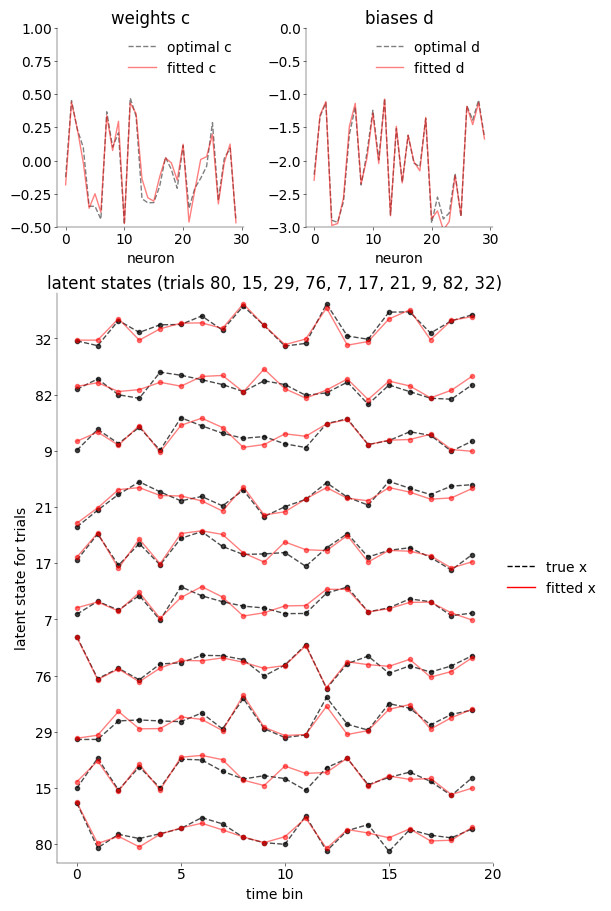

In [67]:
from matplotlib.gridspec import GridSpec

# ------------------------------------------------------
# Plot ground truth vs. inferred model
# Plot the weights `C`, biases `d` and latent states (2 pts)
# ------------------------------------------------------
fig = plt.figure(figsize=(6, 9))
gs = GridSpec(2, 2, height_ratios=[0.7, 2.0], figure=fig)
ax_C = fig.add_subplot(gs[0, 0])
ax_d = fig.add_subplot(gs[0, 1])
ax_latent = fig.add_subplot(gs[1, :])
ax = {"C": ax_C, "d": ax_d, "latent": ax_latent}

# plot weights c
ax["C"].set_title("weights c")
ax["C"].plot(training_set.params["C"], "k--", label="optimal c", alpha=0.5)
ax["C"].plot(fitToy.optimParams["C"], "r", label="fitted c", alpha=0.5)
ax["C"].legend(loc="upper right")
ax["C"].set_xlabel("neuron")
ax["C"].set_ylim(-0.5, 1.0)

# plot biases d
ax["d"].set_title("biases d")
ax["d"].plot(training_set.params["d"], "k--", label="optimal d", alpha=0.5)
ax["d"].plot(fitToy.optimParams["d"], "r", label="fitted d", alpha=0.5)
ax["d"].legend(loc="upper right")
ax["d"].set_xlabel("neuron")
ax["d"].set_ylim(-3.0, 0)

# plot latent states for selected trials
ax["latent"].set_title(f"latent states (trials {', '.join(map(str, idx + 1))})")
lines_true = ax["latent"].plot(
    x_true, "k--", marker=".", linestyle="--", alpha=0.7
)  # plot ground truth latent states
lines_est = ax["latent"].plot(
    x_est, "r", marker=".", linestyle="-", alpha=0.5
)  # plot inferred latent states
ax["latent"].plot([], [], "k--", label="true x")  # dummy for legend
ax["latent"].plot([], [], "r", label="fitted x")  # dummy for legend
# Place legend outside the plot to the right
ax["latent"].legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
ax["latent"].set_xlabel("time bin")
ax["latent"].set_xticks(np.arange(0, 21, 5))
ax["latent"].set_xticks(np.arange(0, 21, 5), minor=True)
ax["latent"].set_ylabel("latent state for trials")

# set y-limits to fit the plotted latent states
all_latents = np.concatenate([x_true.flatten(), x_est.flatten()])
ax["latent"].set_ylim(all_latents.min() - 1, all_latents.max() + 1)
ax["latent"].set_yticks(
    np.arange(int(all_latents.min()), int(all_latents.max()) + 1, 5)
)
# set y-ticks to correspond to the selected trial indices (1-based)
ax["latent"].set_yticklabels(idx + 1)
# show the plot
plt.show()

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 4 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [56]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [57]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log-likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$$
p_\lambda(x_t) = \frac{e^{-\lambda} \lambda^{x_t}}{x_t!}
$$

$$
L(\lambda_k; x_1, \ldots, x_N) = \prod_{t=1}^{N} p_\lambda(x_t) = \prod_{t=1}^{N} \frac{e^{-\lambda_k} \lambda_k^{x_t}}{x_t!}
$$

\begin{align*}
\log(L) = \ell(\lambda_k; x_1, \ldots, x_N) &= \log( \prod_{t=1}^{N} \frac{e^{-\lambda_k} \lambda_k^{x_t}}{x_t!}) \\
&= -N \lambda_k + \left( \sum_{t=1}^{N} x_t \right) \log \lambda_k - \sum_{t=1}^{N} \log(x_t!)
\end{align*}

$$
\ell(\lambda_k; x_1, \ldots, x_N) = \sum_{t=1}^{N} \left( -\lambda_k + x_t \log \lambda_k - \log(x_t!) \right)
$$


In [68]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# do the actual cross validation
xval = util.crossValidation(
    data,
    numTrainingTrials=80,
    numTestTrials=20,
    maxXdim=5,
    maxEMiter=10,
    learningMethod="batch",
)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   10 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  10 of  10, nPLL: = -397.3991Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above). Note: We assume a constant firing rate across trials, but not necessarily across time.

In [73]:
# --------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (1 pt)
# --------------------------------------------------------------------------------

train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)
# compute errors for the different models

# constant across trials mean: since for a constant rate model, there is no influence of the latent state on the firing rate, which previously - apart from noise - was the only source of variability across trials,
# now the variability across trials is only due to the noise in the spike counts.

# Compute baseline error (SSE) for a constant rate model (no latent variable)
# For each neuron and time bin, use the mean firing rate across training trials as prediction

# define the training and test sets
train_set = np.stack([data_["Y"] for data_ in train_set.data])
# compute mean firing rate across training trials
rates = train_set.mean(axis=0)
# define the test set
test_set = np.stack([data_["Y"] for data_ in test_set.data])
# compute the baseline error (SSE) for a constant rate model
baseline = np.sum((test_set - rates[np.newaxis, :, :]) ** 2)

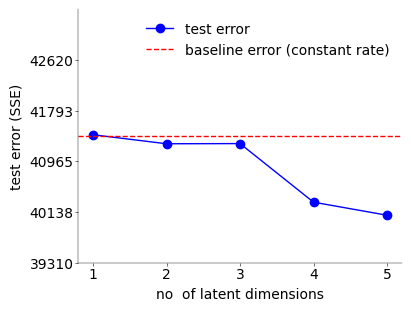

In [77]:
# -------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models
# and answer the questions below (1+1 pts)
# -------------------------------------------------------------------------


# Your plot here
fig, ax = plt.subplots(figsize=(4, 3))

# barplot model error
ax.plot(
    np.arange(1, xval.maxXdim + 1),
    xval.errs,
    label="test error",
    color="blue",
    linestyle="-",
    marker="o",
)

# plot baseline
ax.axhline(baseline, linestyle="--", c="red", label="baseline error (constant rate)")
ax.legend(loc="upper right")
ax.set_xlabel("no  of latent dimensions")
ax.set_ylabel("test error (SSE)")
ax.set_ylim(0.95 * baseline, 1.05 * baseline)
ax.set_yticks(
    np.arange(0.95 * baseline, 1.05 * baseline, (1.05 * baseline - 0.95 * baseline) / 5)
)

### Questions


1. Is the baseline error (0 latents) about what you expect in relation to the other models? Why or why not?

The baseline error is higher than the models with more than one latent variables, as expected, however, surprisingly one latent variable does even increase the SSE. The constant rate model cannot capture trial-to-trial variability or temporal structure, so even a single latent variable should improve the fit. However, the improvement is modest for 1–3 latents, suggesting the data has more complex structure that requires more latent dimensions.

2. Can you identify a "best model"? If so, which is it and what does this say about the structure of the latent state?

The lowest test error is achieved with 5 latent variables for the shown run, yet in another run the best fit was achieved for 4 latent variables, indicating that the data contains multiple sources of shared variability. This suggests the latent state is multidimensional and cannot be captured by just one or two factors.

## Task 3. Visualization: population rasters and latent state.
Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_7861/2156563041.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


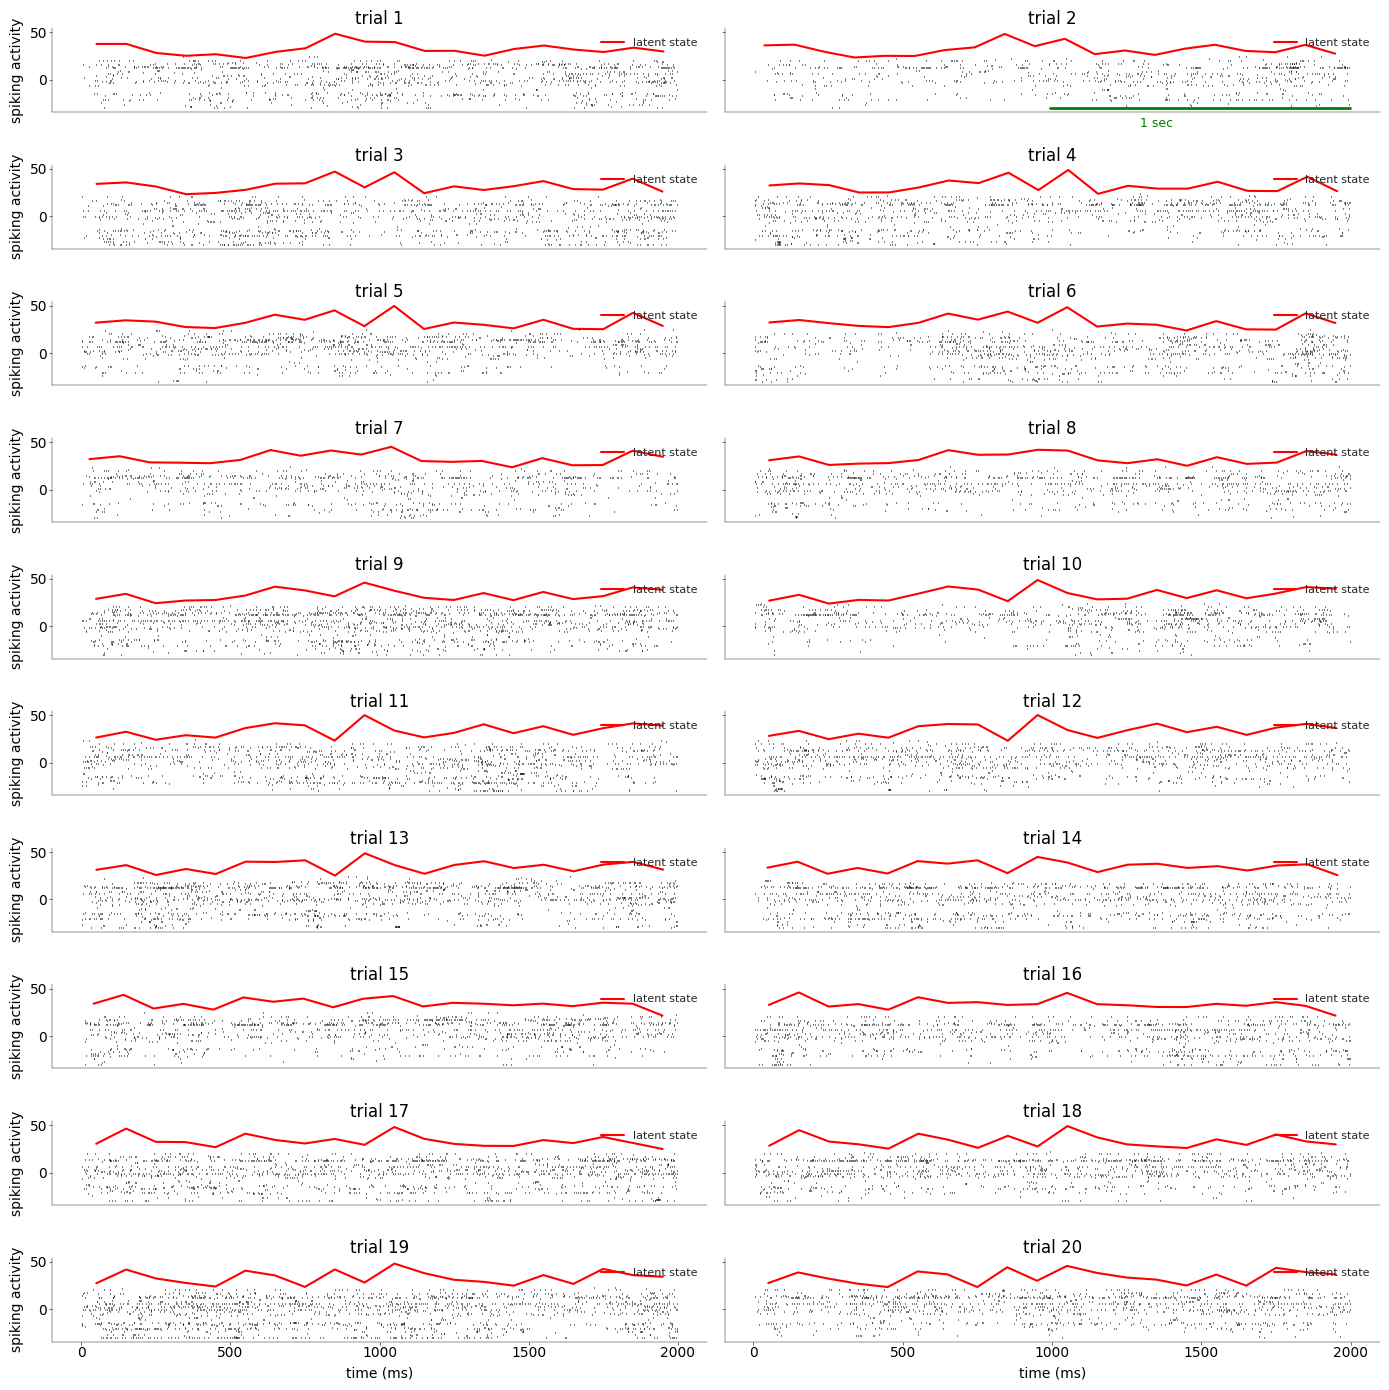

In [ ]:
# plot raster and latent state for first 20 trials, with improved comments, legends, and axis ticks

fig, axs = plt.subplots(10, 2, figsize=(14, 14), sharey=True)

# get estimated latent states for first 20 trials
x_est = allTrialsState(xval.fits[0], 1).reshape(20, -1)

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        # time bins (assuming binsize of 100 ms)
        time_bins = np.arange(50, 2000, 100)

        # plot latent state (scaled and offset for visibility)
        ax.plot(
            time_bins,
            x_est[:, ntrial] * 5 + 35,
            color="red",
            linewidth=1.5,
            label="latent state",
        )

        # sort neurons by their weights c_k
        sorted_idx = np.argsort(xval.fits[0].optimParams["C"].flatten())

        # plot spike raster for each neuron
        for n, neuron in enumerate(data.data[ntrial]["spike_time"][sorted_idx]):
            spikes = neuron[(neuron >= 0) & (neuron <= 2000)]
            ax.vlines(
                spikes,
                n - 30,
                n + 1 - 30,
                color="black",
                linewidth=0.75,
            )
        ax.set_title(f"trial {ntrial + 1}")

        # add legend to first subplot
        if ntrial == 0:
            ax.legend(loc="upper right", fontsize=8)
        # add scale bar to second subplot
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green", linewidth=2)
            ax.text(1300, -50, "1 sec", color="green", fontsize=9)

        # set x-ticks: show ms
        if ntrial >= 18:
            ax.set_xticks([0, 500, 1000, 1500, 2000])
            ax.set_xticklabels([0, 500, 1000, 1500, 2000])
            ax.set_xlabel("time (ms)")
        else:
            ax.set_xticks([])
        if ntrial % 2 == 0:
            ax.set_ylabel("spiking activity")

plt.tight_layout()
plt.show()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

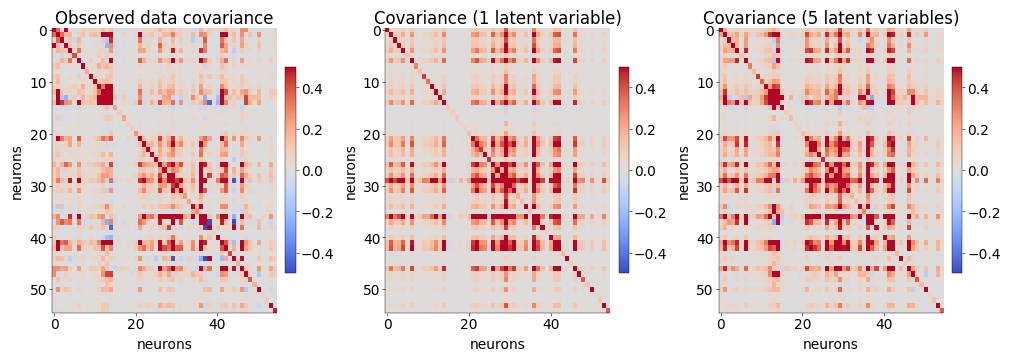

In [93]:
# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    """compute the analytical covariance matrix of the approximation using the provided equations."""
    # extract parameters
    C = fit.optimParams["C"]  # (ydim, xdim)
    d = fit.optimParams["d"]  # (ydim,)
    post_mean = fit.infRes["post_mean"]  # list of arrays, one per trial

    # stack all trials to shape (n_trials, xdim, T)
    X = np.stack(post_mean, axis=0)  # (n_trials, xdim, T)
    X_mean = np.mean(X, axis=0)  # (xdim, T)

    # initialize covariance across trials for each time step
    X_cov = np.zeros((fit.xdim, fit.xdim, X.shape[2]))  # (xdim, xdim, T)
    for t in range(X.shape[2]):
        # covariance across trials at time t
        X_cov[:, :, t] = np.cov(X[:, :, t], rowvar=False, bias=True)

    # compute mean and covariance for each time bin
    ydim = C.shape[0]
    T = X.shape[2]
    mu = np.zeros((ydim, T))
    covs = np.zeros((ydim, ydim, T))
    for t in range(T):
        # mean of log-normal
        m = C @ X_mean[:, t] + d  # (ydim,)
        S = C @ X_cov[:, :, t] @ C.T  # (ydim, ydim)
        mu[:, t] = np.exp(m + 0.5 * np.diag(S))  # mean vector of log-normal
        outer = np.outer(mu[:, t], mu[:, t])
        covs[:, :, t] = outer * (np.exp(S) - 1)  # analytical covariance
        covs[:, :, t] += np.diag(mu[:, t])  # add poisson variance

    # average over time bins
    cov_avg = np.mean(covs, axis=2)  # (ydim, ydim)
    return cov_avg, np.mean(mu, axis=1)


# --------------------------------------------------------------
# Plot the covariance matrix of
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# and explain how they compare (1+1 pts).
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

# HINT: Think about which type of colormap and ranges are appropriate here.

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))


# add plot to visualize the differences in the covariance matrices
def plot_cov(ax, cov_matrix, title):
    """Plot the covariance matrix."""
    im = ax.imshow(
        cov_matrix,
        cmap="coolwarm",
        vmin=-0.5,
        vmax=0.5,
        aspect="auto",
        interpolation="nearest",
    )
    ax.set_title(title)
    ax.set_xlabel("neurons")
    ax.set_ylabel("neurons")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


plot_cov(axs[0], obs_corr, "Observed data covariance")
plot_cov(axs[1], opt_r1, "Covariance (1 latent variable)")
plot_cov(axs[2], opt_r5, "Covariance (5 latent variables)")
plt.show()

### Questions

What do you see / expect to see?

Generally, the covariance matrix of the observed data should show a lot of structure, with neurons that are more similar in their firing rates having higher covariance. The approximation using one latent variable should capture some of this structure, but likely not all, leading to a more sparse covariance matrix. The approximation using five latent variables should capture much more of the structure, leading to a denser covariance matrix that resembles the original observed data covariance matrix more closely. Inspecting the heatmaps, we are surprised that 1 and 5 latent variables lead to very similar covariance matrices, though especially for the first 15 neurons the model with 5 latent variables captures more of the structure.